In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
import torch
print("Torch version:", torch.__version__)
print("CUDA version PyTorch was built with:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

Torch version: 2.3.1
CUDA version PyTorch was built with: None
Is CUDA available: False


In [2]:
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 500]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 500]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 500]

def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)

In [3]:
val_steps = np.random.randint(1,199,(val_sims.shape[0],))
val_points = np.random.randint(0,149,(val_sims.shape[0],2))

In [4]:
def darcy_loss(model, inp):
    inp = inp.requires_grad_(True)
    out = model(inp)

    # Impose high pressure along the entire upper line

    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad
    loss = (final**2).mean()



    return loss, out

In [5]:
class TwoConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)
    
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))
    
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        upsampled = self.up(below)
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        concat = torch.concat((upsampled, across), dim=-3)
        return self.conv_after(concat)
    
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):

        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2))
        x4 = self.d4(x3)
        x5 = self.d5(x4)

        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2)
        up = self.u4(up, x1)
        up = self.u5(up, top)

        return self.final(up)

In [6]:
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self, sims, unmask_size=20, points = None, steps = None):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size

    def __getitem__(self, index):
        if not type(self.points) == np.ndarray:
            point = np.random.randint(0, 200-self.size, size=(2,))
        else:
            point = self.points[index]
        if not type(self.steps) == np.ndarray:
            step = np.random.randint(1,200)
        else:
            step = self.steps[index]

        t = torch.tensor(get_all(self.sims[index], step))
        z = torch.zeros_like(t)

        print("t.shape on this machine:", tuple(t.shape))


        x0, x1 = point[0], point[0] + self.size
        y0, y1 = point[1], point[1] + self.size

        z[..., x0:x1, y0:y1] = t[..., x0:x1, y0:y1]


        # z[:,point[0]:point[0]+self.size,point[1]:point[1]+self.size] = t[:,point[0]:point[0]+self.size,point[1]:point[1]+self.size]
        
        return z,t
    
    def __len__(self):
        return self.sims.shape[0]
    
train_loader = torch.utils.data.DataLoader(MaskedDataset(train_sims, unmask_size=50), batch_size=8)
val_data = MaskedDataset(val_sims, unmask_size=50, points=val_points, steps=val_steps)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [7]:
class SimpleConvModel(nn.Module):
    def __init__(self):
        super(SimpleConvModel, self).__init__()

        self.c = nn.Parameter(torch.tensor(1, dtype=torch.float32), requires_grad=True)
        
        # Encoder-like part (keeps size with padding)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # input: (B,1,200,200)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (B,32,200,200)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (B,64,200,200)

        # Decoder-like part
        self.deconv1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.deconv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.out = nn.Conv2d(16, 3, kernel_size=3, padding=1)  # output: (B,1,200,200)

    def forward(self, x):
        # Encoding
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoding
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.out(x))  # sigmoid for [0,1] image output

        return x
    
#model = SimpleConvModel().to(device)

In [8]:
model = SmallUnet().to(device)
optim = torch.optim.Adam(model.parameters())
schedule = torch.optim.lr_scheduler.ExponentialLR(optim, 0.99)
crit = nn.MSELoss()

In [9]:
sum([k.numel() for k in model.parameters()])

2527461

In [10]:
epochs = 250
losses = []
darcy = []

val_loss = []
val_darcy = []
for e in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_darcy = 0
    for feat,label in train_loader:
        optim.zero_grad()
        feat = feat.to(device)
        label = label.to(device)
        p_loss, out = darcy_loss(model, feat)
        epoch_darcy += p_loss.item()
        loss = crit(out, label)
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
    epoch_loss /= train_loader.__len__()
    epoch_darcy /= train_loader.__len__()
    losses.append(epoch_loss)
    darcy.append(epoch_darcy)

    schedule.step()

    epoch_loss = 0
    epoch_darcy = 0
    for feat,label in val_loader:

        feat = feat.to(device)
        label = label.to(device)
        p_loss, out = darcy_loss(model, feat)
        epoch_darcy += p_loss.item()
        loss = p_loss + crit(out, label)
        epoch_loss += loss.item()

    epoch_loss /= val_loader.__len__()
    epoch_darcy /= val_loader.__len__()
    val_loss.append(epoch_loss)
    val_darcy.append(epoch_darcy)

  0%|          | 0/250 [00:00<?, ?it/s]


t.shape on this machine: (3,)


IndexError: too many indices for tensor of dimension 1

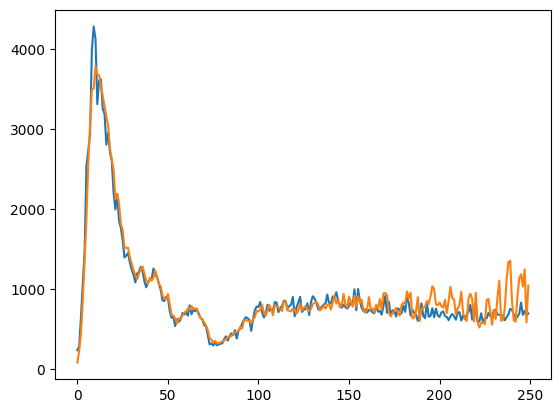

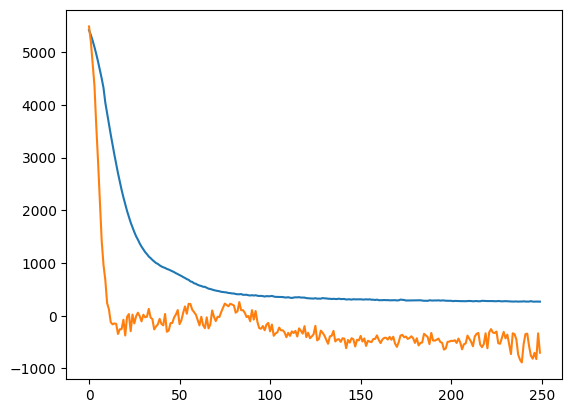

In [ ]:
plt.plot(np.array(val_darcy))
plt.plot(np.array(darcy))
plt.show()
plt.plot(np.array(val_loss) - np.array(val_darcy))
plt.plot(np.array(losses) - np.array(darcy))
plt.show()

In [ ]:
torch.save(model, "small_unet_darcy_50_nodarcy.pt")

Now to actual evaluation

In [ ]:
both_model = torch.load("small_unet_darcy_50_both-b1.pt", weights_only=False).to(device)
darcy_model = torch.load("small_unet_darcy_50_nomse.pt", weights_only=False).to(device)
mse_model = torch.load("small_unet_darcy_50_nodarcy.pt", weights_only=False).to(device)

In [ ]:
def vis(tensor):
    return tensor.cpu().detach().numpy()

def show_evaluation(model, indices, data=val_data):

    fig, axs = plt.subplots(len(indices), 6, dpi=600)

    axs[0,0].set_title("Given K", fontsize=8)
    axs[0,1].set_title("Predicted K",fontsize=8)
    axs[0,2].set_title("Actual K",fontsize=8)

    axs[0,3].set_title("Given Pres",fontsize=8)
    axs[0,4].set_title("Predicted Pres",fontsize=8)
    axs[0,5].set_title("Actual Pres",fontsize=8)

    for i,e in enumerate(indices):
        sample = val_data.__getitem__(e)
        out = model(sample[0].to(device).unsqueeze(0))[0]

        axs[i,0].imshow(vis(sample[0][0]), cmap='gray', vmin=0, vmax=255)
        axs[i,1].imshow(vis(out[0]), cmap='gray', vmin=0, vmax=255)
        axs[i,2].imshow(vis(sample[1][0]), cmap='gray', vmin=0, vmax=255)

        axs[i,3].imshow(vis(sample[0][1]), cmap='gray', vmin=0, vmax=255)
        axs[i,4].imshow(vis(out[1]), cmap='gray', vmin=0, vmax=255)
        axs[i,5].imshow(vis(sample[1][1]), cmap='gray', vmin=0, vmax=255)

    for axs in fig.get_axes():
        axs.axis('off')
    fig.tight_layout()
    plt.show()

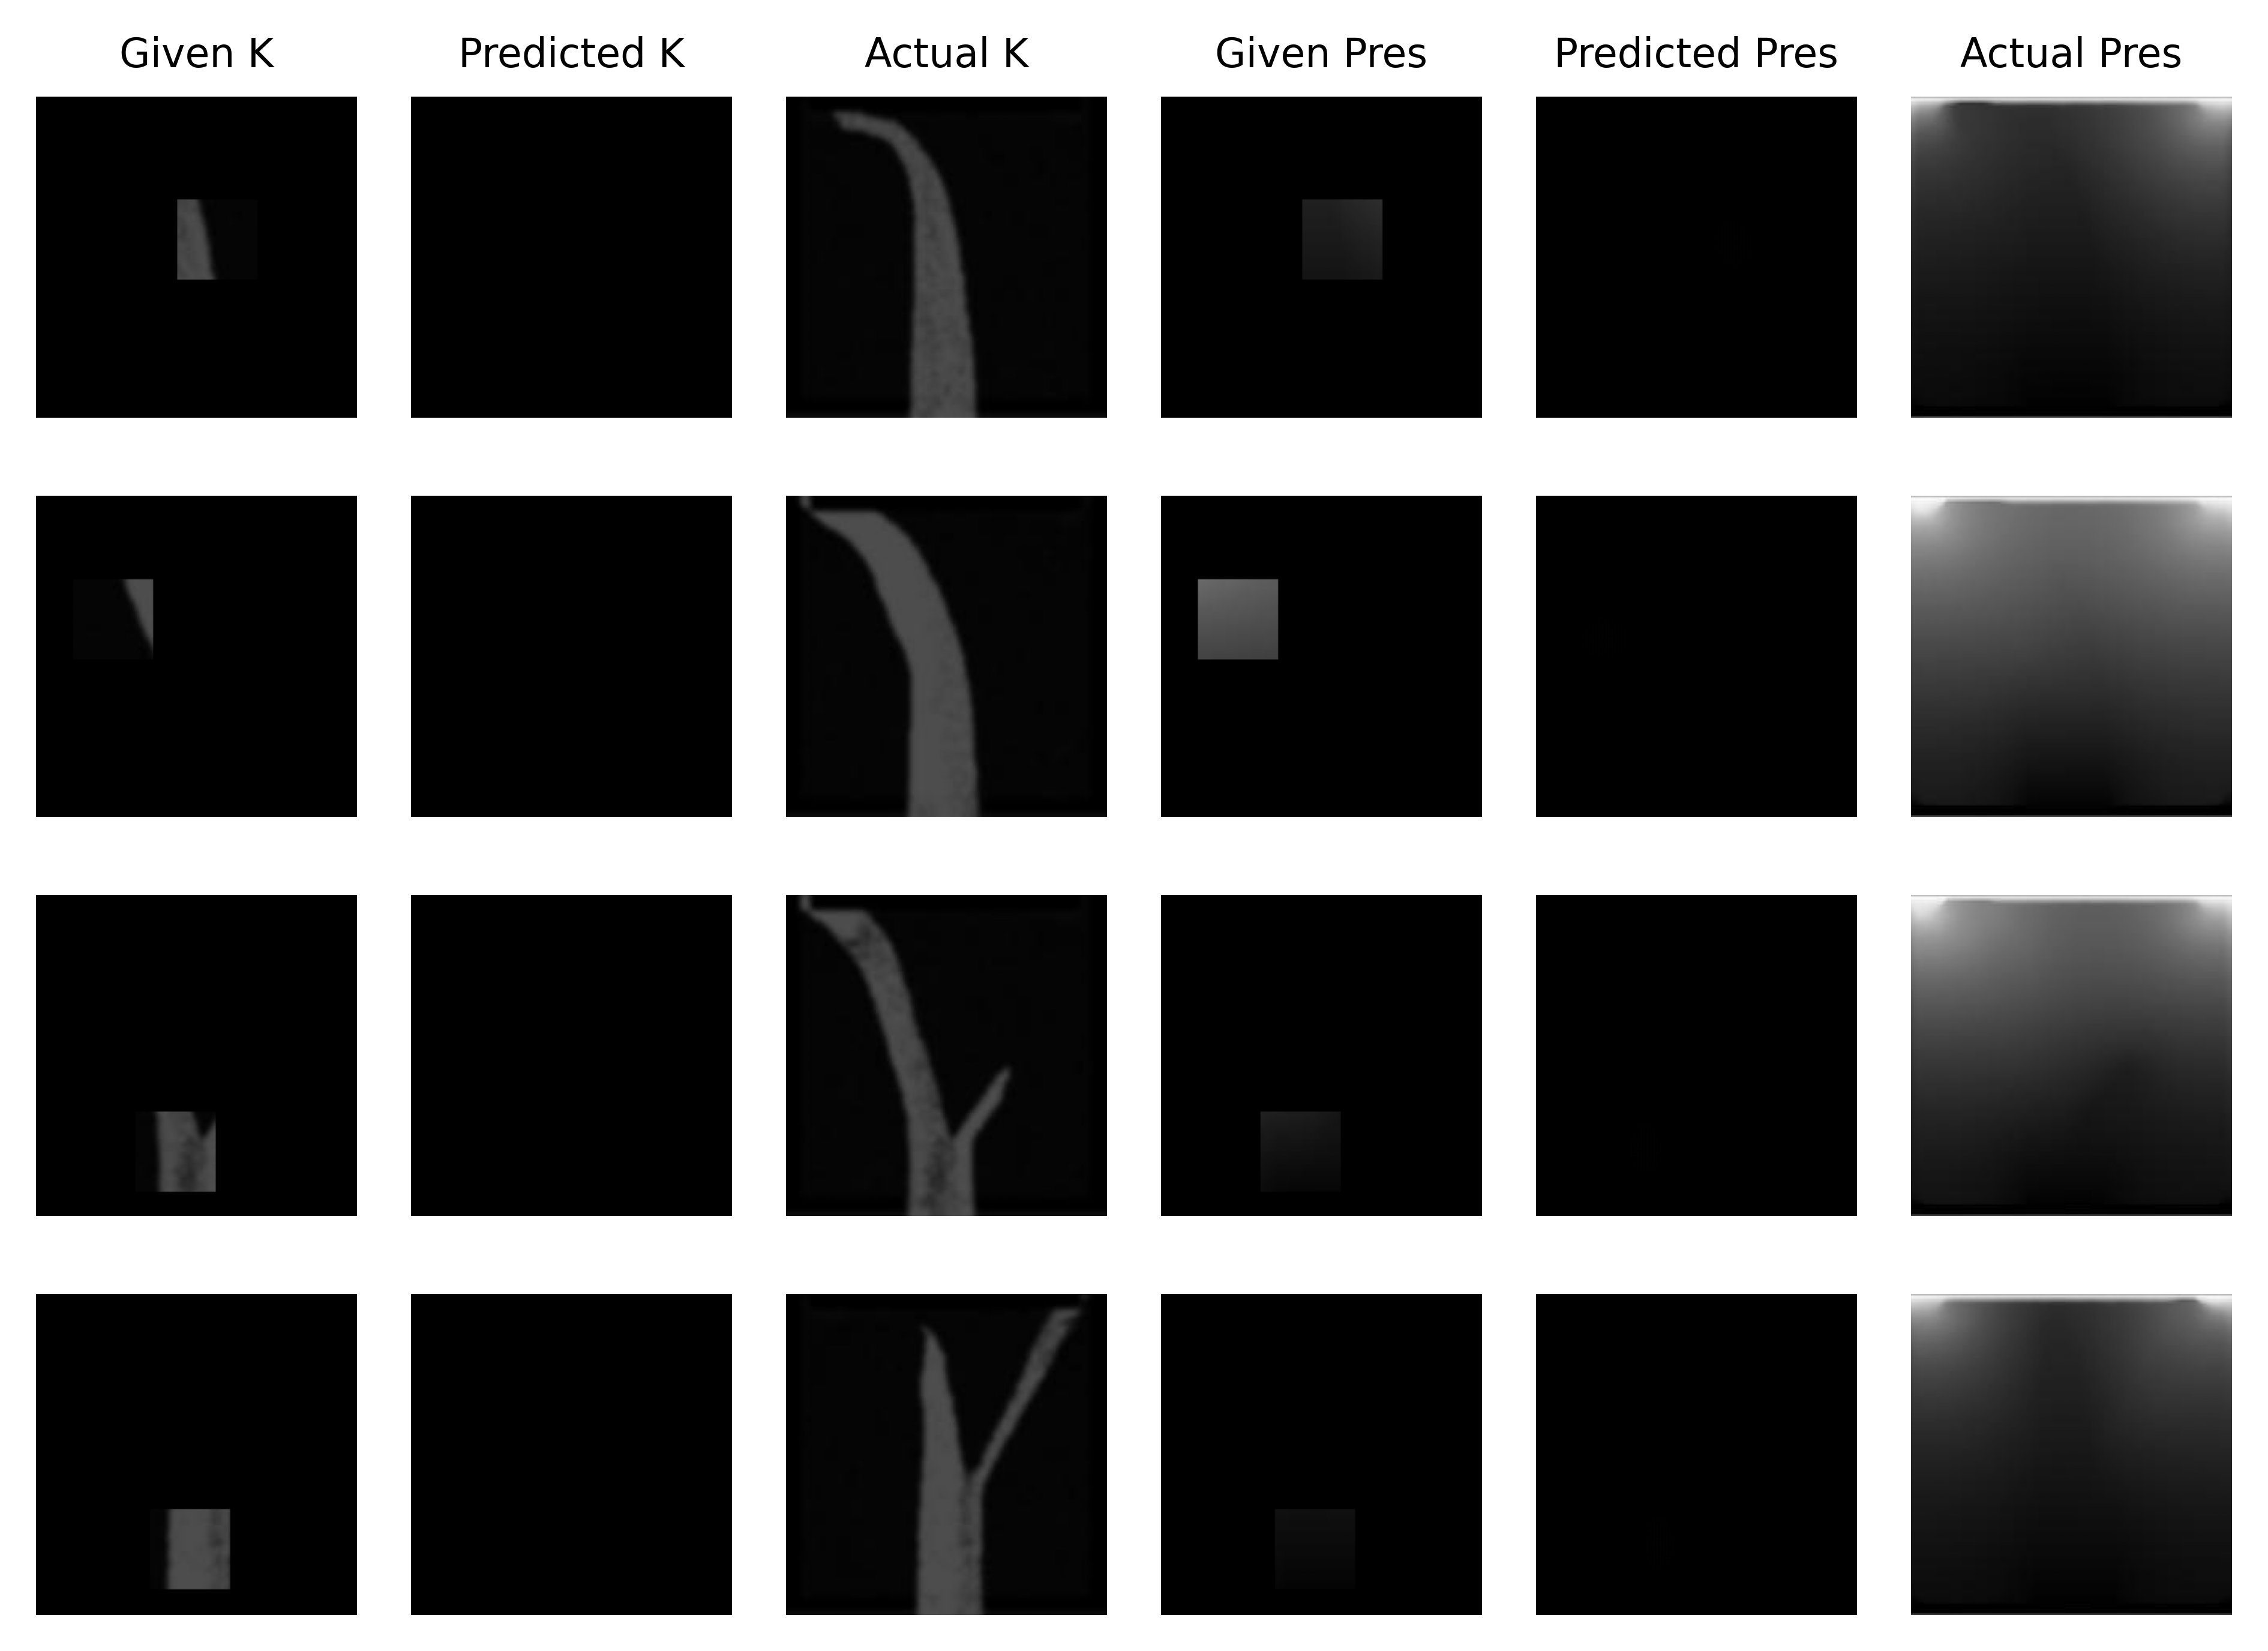

In [ ]:
# Model using only darcy loss
show_evaluation(darcy_model, [9,6,12,17])

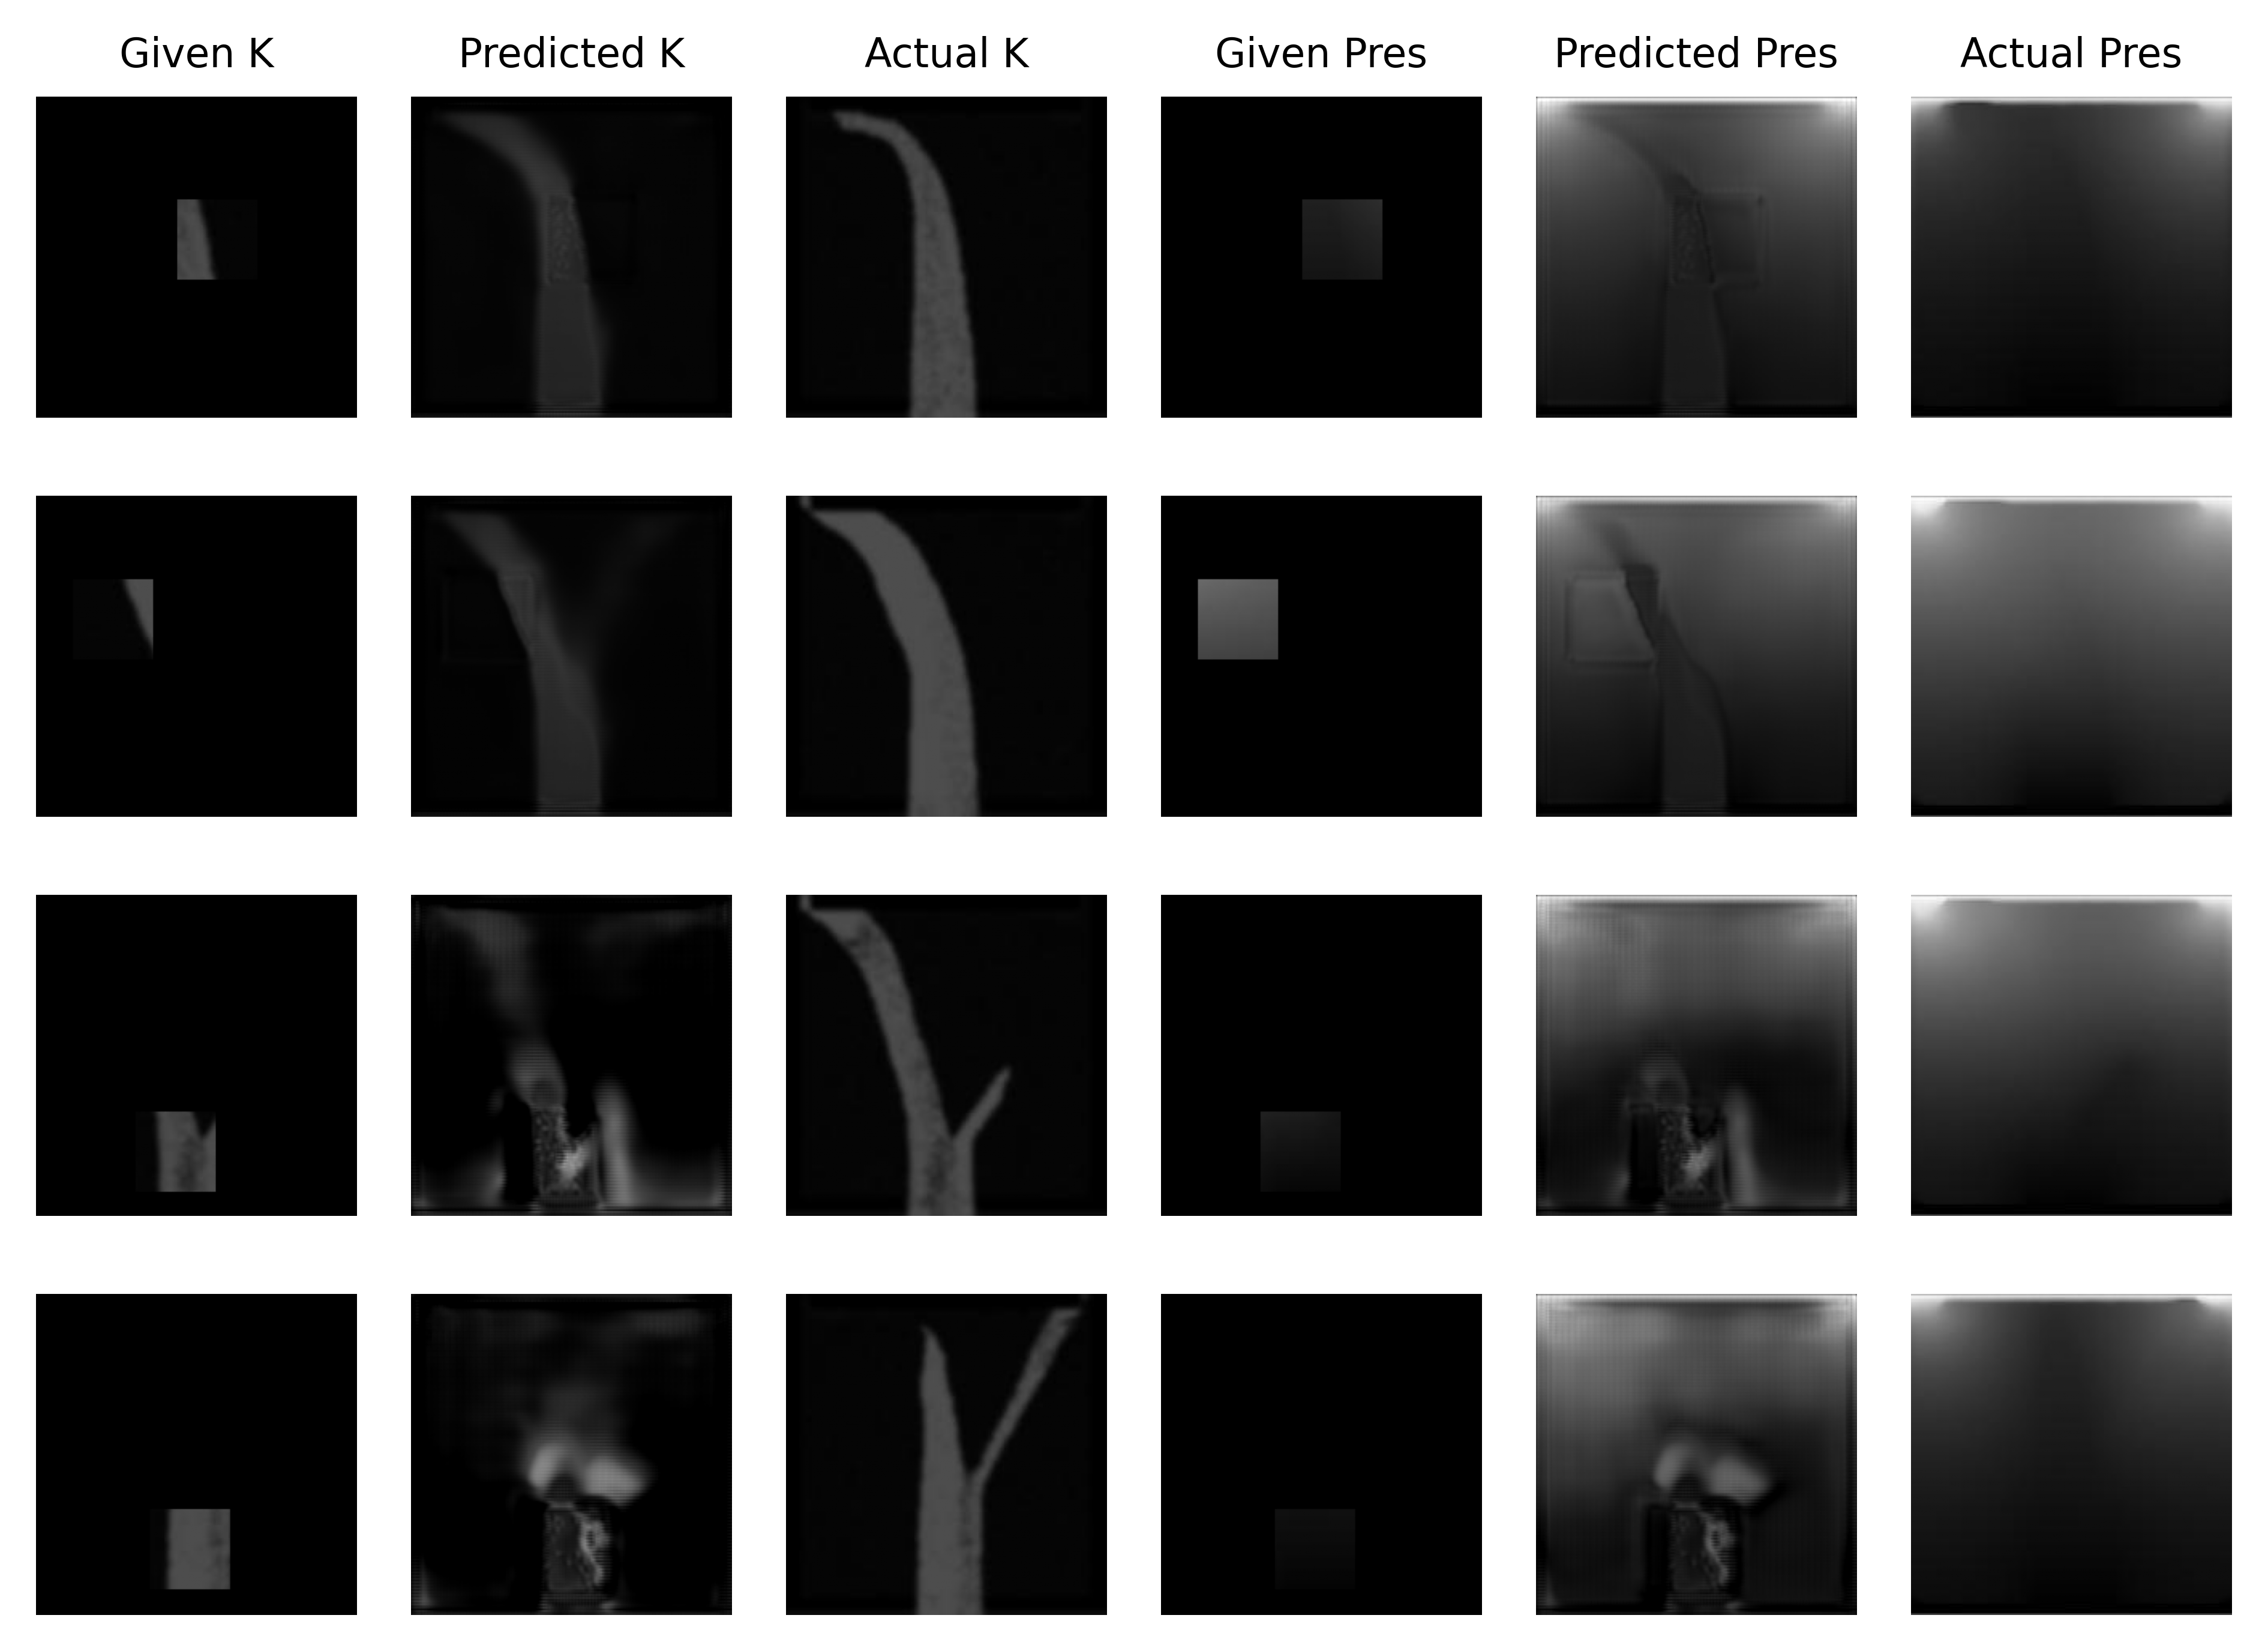

In [ ]:
# Model using only darcy loss
show_evaluation(mse_model, [9,6,12,17])

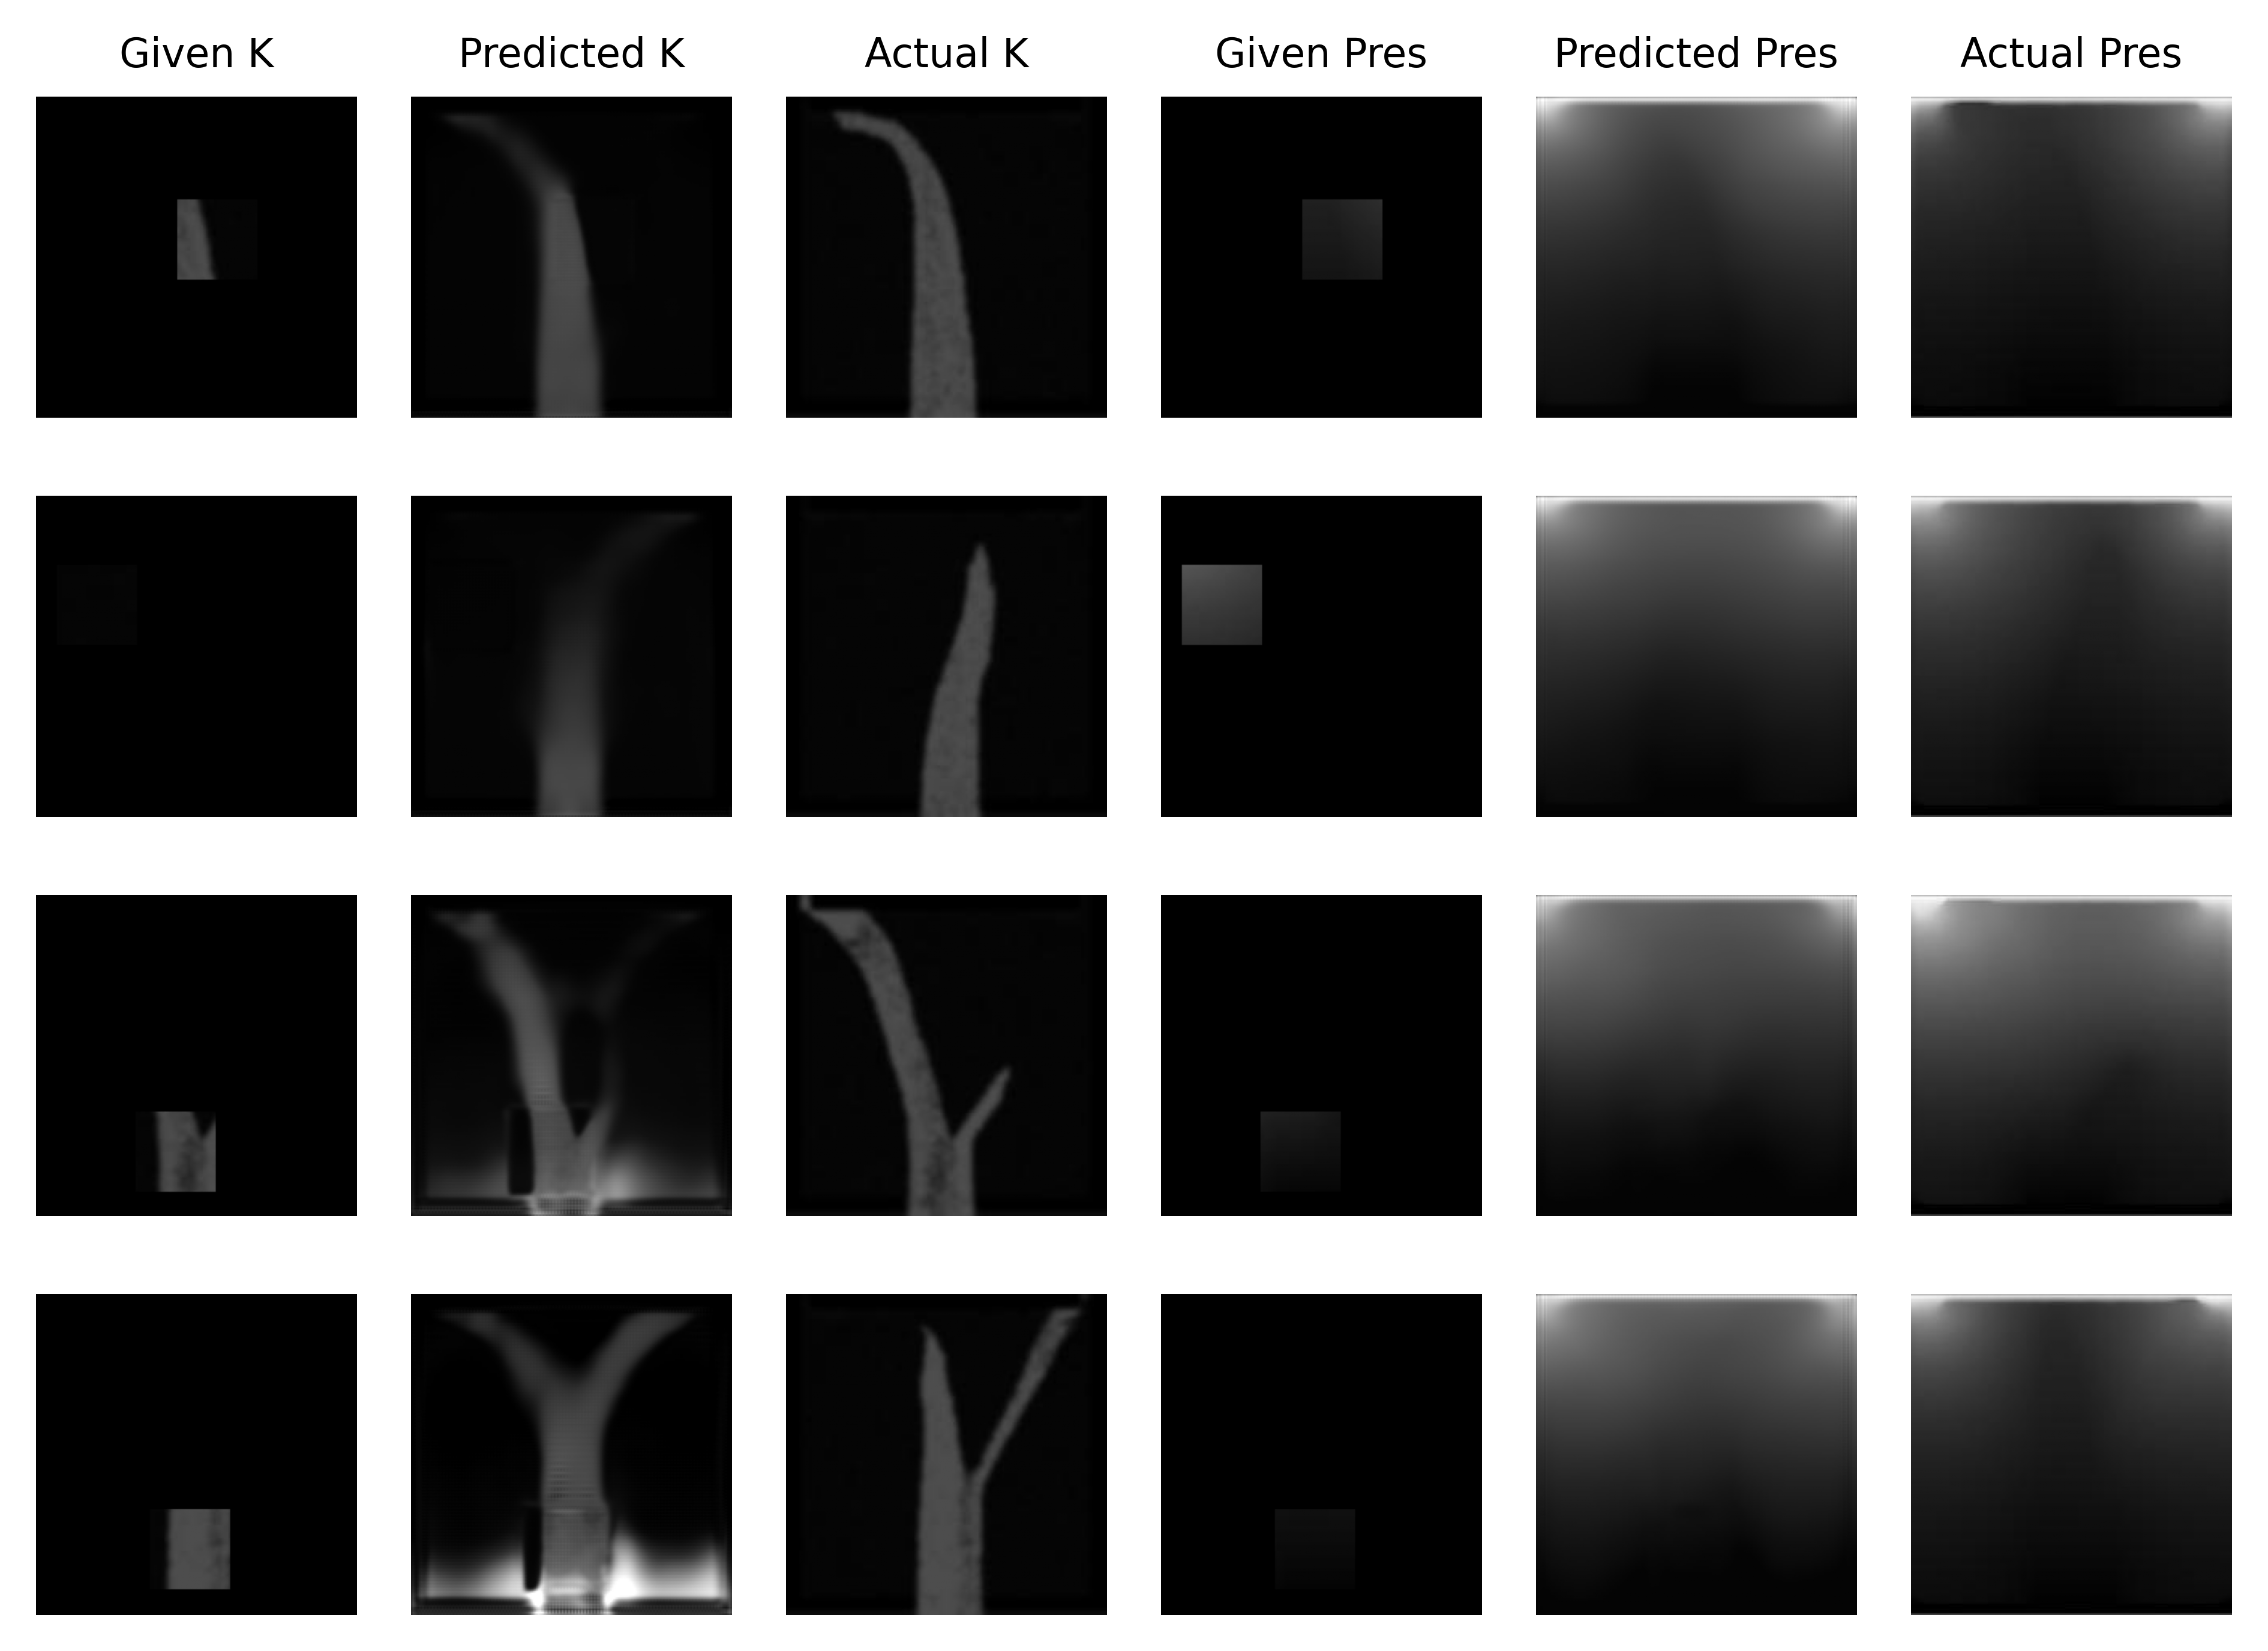

In [ ]:
show_evaluation(both_model, [9,2,12,17])